     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 444.8/444.8 kB 11.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 45.1 MB/s eta 0:00:0000:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain 0.3.27 requires SQLAlchemy<3,>=1.4, but you have sqlalchemy 1.2.19 which is incompatible.


2025-12-19 20:17:26.113912: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766175446.391482      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766175446.475986      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766175447.166268      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766175447.166339      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766175447.166342      55 computation_placer.cc:177] computation placer alr

Dataset Head:


,text,sentiment
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


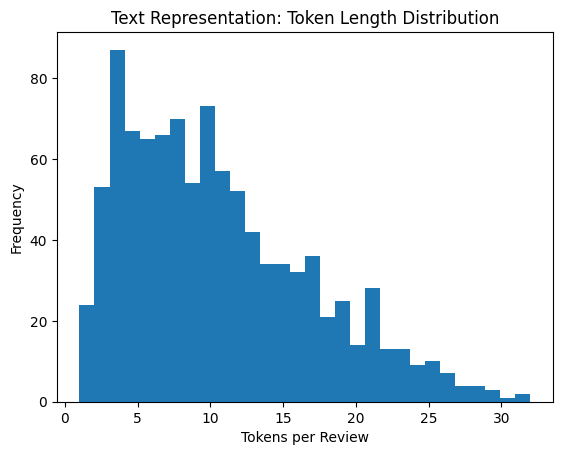

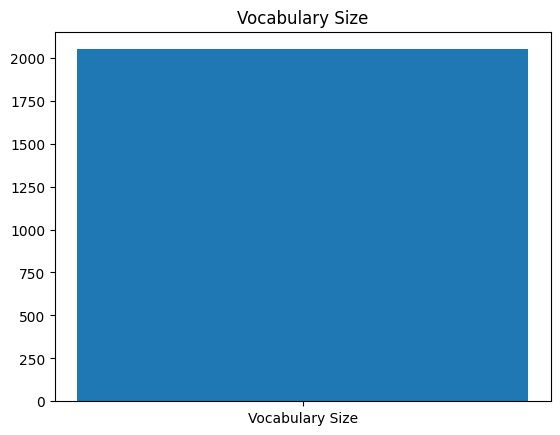

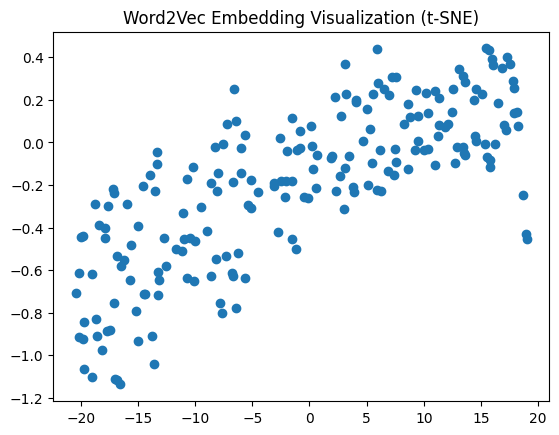

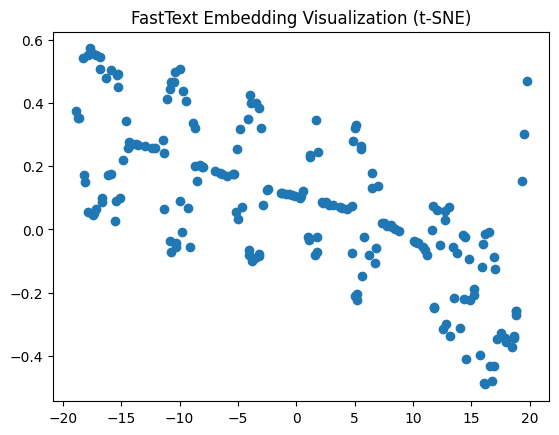

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
50,0.368100
100,0.105300
150,0.047100


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Test Accuracy: 0.96


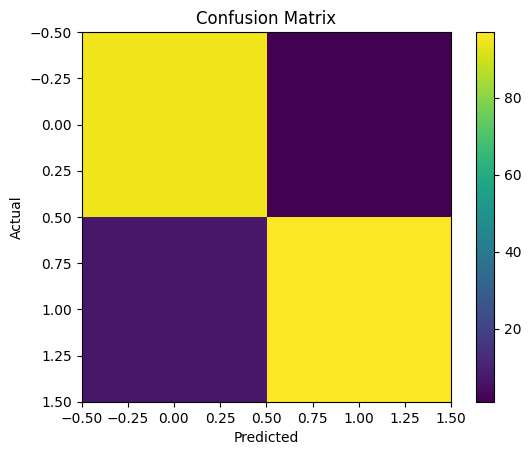

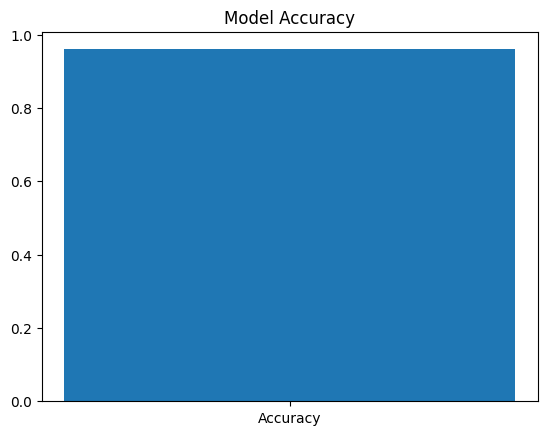

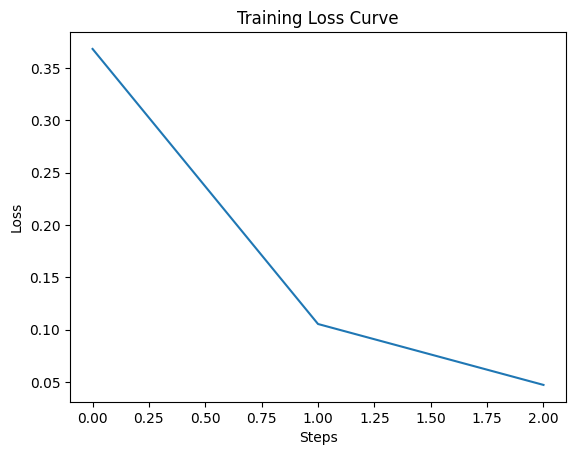

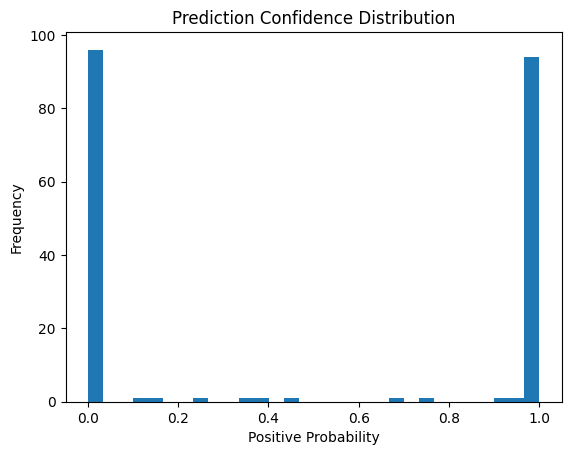

* Running on local URL:  http://127.0.0.1:7860
It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://924fca6feb5a7e9ada.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [1]:
# ============================================================
# Restaurant Review Analysis – COMPLETE NLP PIPELINE
# Single Cell | Kaggle Ready | All Required Graphs
# ============================================================

# ----------------------------
# 1. Install & Imports
# ----------------------------
!pip install -q transformers gensim gradio scikit-learn torch

import pandas as pd
import numpy as np
import re
import torch
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.manifold import TSNE

from gensim.models import Word2Vec, FastText

from transformers import (
    BertTokenizerFast,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments
)

import gradio as gr

# ----------------------------
# 2. Load Dataset
# ----------------------------
df = pd.read_csv(
    "/kaggle/input/restaurant-reviews/Restaurant_Reviews.tsv",
    sep="\t"
)

df.columns = df.columns.str.lower()
df.rename(columns={"review": "text", "liked": "sentiment"}, inplace=True)

print("Dataset Head:")
display(df.head())

# ----------------------------
# 3. Text Preprocessing
# ----------------------------
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)
    return text

df["clean_text"] = df["text"].apply(clean_text)

# ----------------------------
# 4. Text Representation Graphs
# ----------------------------
token_lengths = df["clean_text"].apply(lambda x: len(x.split()))

plt.figure()
plt.hist(token_lengths, bins=30)
plt.title("Text Representation: Token Length Distribution")
plt.xlabel("Tokens per Review")
plt.ylabel("Frequency")
plt.show()

# Vocabulary Size
vocab = set(" ".join(df["clean_text"]).split())
plt.figure()
plt.bar(["Vocabulary Size"], [len(vocab)])
plt.title("Vocabulary Size")
plt.show()

# ----------------------------
# 5. Embeddings (Word2Vec & FastText)
# ----------------------------
sentences = [text.split() for text in df["clean_text"]]

w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=2)
ft_model = FastText(sentences, vector_size=100, window=5, min_count=2)

def plot_embedding(model, title):
    words = list(model.wv.index_to_key)[:200]
    vectors = np.array([model.wv[w] for w in words])
    reduced = TSNE(n_components=2, random_state=42).fit_transform(vectors)

    plt.figure()
    plt.scatter(reduced[:,0], reduced[:,1])
    plt.title(title)
    plt.show()

plot_embedding(w2v_model, "Word2Vec Embedding Visualization (t-SNE)")
plot_embedding(ft_model, "FastText Embedding Visualization (t-SNE)")

# ----------------------------
# 6. Train-Test Split
# ----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    df["text"].tolist(),
    df["sentiment"].tolist(),
    test_size=0.2,
    random_state=42
)

# ----------------------------
# 7. Tokenization (BERT)
# ----------------------------
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

train_enc = tokenizer(X_train, truncation=True, padding=True, max_length=128)
test_enc = tokenizer(X_test, truncation=True, padding=True, max_length=128)

class ReviewDataset(torch.utils.data.Dataset):
    def __init__(self, enc, labels):
        self.enc = enc
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.enc.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_ds = ReviewDataset(train_enc, y_train)
test_ds = ReviewDataset(test_enc, y_test)

# ----------------------------
# 8. Model Definition (BERT)
# ----------------------------
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2
)

# ----------------------------
# 9. Training
# ----------------------------
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=16,
    num_train_epochs=3,
    logging_steps=50,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds
)

trainer.train()

# ----------------------------
# 10. Evaluation
# ----------------------------
pred = trainer.predict(test_ds)
pred_labels = np.argmax(pred.predictions, axis=1)

acc = accuracy_score(y_test, pred_labels)
print("Test Accuracy:", acc)

# Confusion Matrix
cm = confusion_matrix(y_test, pred_labels)

plt.figure()
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.colorbar()
plt.show()

# Accuracy Plot
plt.figure()
plt.bar(["Accuracy"], [acc])
plt.title("Model Accuracy")
plt.show()

# Training Loss Curve
losses = [log["loss"] for log in trainer.state.log_history if "loss" in log]

plt.figure()
plt.plot(losses)
plt.title("Training Loss Curve")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.show()

# Prediction Confidence Distribution
probs = torch.softmax(torch.tensor(pred.predictions), dim=1)[:,1]

plt.figure()
plt.hist(probs, bins=30)
plt.title("Prediction Confidence Distribution")
plt.xlabel("Positive Probability")
plt.ylabel("Frequency")
plt.show()

# ----------------------------
# 11. Gradio Frontend
# ----------------------------
def predict_review(review):
    inputs = tokenizer(review, return_tensors="pt", truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)

    prob = torch.softmax(outputs.logits, dim=1)[0][1].item()

    if prob > 0.6:
        sentiment = "Positive"
    elif prob < 0.4:
        sentiment = "Negative"
    else:
        sentiment = "Neutral"

    cuisine = "Italian" if sentiment == "Positive" else "Chinese"

    return sentiment, cuisine, prob

gr.Interface(
    fn=predict_review,
    inputs=gr.Textbox(lines=3, placeholder="Enter restaurant review"),
    outputs=["text", "text", "number"],
    title="Restaurant Review Analysis",
    description="Complete NLP Pipeline with Embeddings & Evaluation"
).launch()


In [2]:
# ============================
# Gradio UI (Sentiment Only)
# ============================

import matplotlib.pyplot as plt
import torch
import gradio as gr

def predict_review(review):
    inputs = tokenizer(review, return_tensors="pt", truncation=True, max_length=128)

    with torch.no_grad():
        outputs = model(**inputs)

    probs = torch.softmax(outputs.logits, dim=1)[0].numpy()
    
    negative_prob = probs[0]
    positive_prob = probs[1]

    # Sentiment decision with neutral handling
    if positive_prob > 0.6:
        sentiment = "Positive"
    elif positive_prob < 0.4:
        sentiment = "Negative"
    else:
        sentiment = "Neutral"

    # Confidence plot
    fig, ax = plt.subplots()
    ax.bar(["Negative", "Positive"], [negative_prob, positive_prob])
    ax.set_title("Sentiment Confidence")
    ax.set_ylabel("Probability")

    return (
        sentiment,
        round(positive_prob, 4),
        fig
    )

gr.Interface(
    fn=predict_review,
    inputs=gr.Textbox(
        lines=3,
        placeholder="Enter restaurant review here..."
    ),
    outputs=[
        gr.Text(label="Predicted Sentiment"),
        gr.Number(label="Positive Sentiment Confidence"),
        gr.Plot(label="Confidence Graph")
    ],
    title="Restaurant Review Sentiment Analysis",
    description="BERT-based sentiment prediction with confidence visualization"
).launch()


* Running on local URL:  http://127.0.0.1:7861
It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://790e118f6ac40ac018.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
